**Project Assignment 4-5:** 

**Team members:**
1. Himanshi Bajaj: 225827  : himanshi.bajaj@st.ovgu.de
2. Sanjeeth Busnur Indushekar: 224133 : sanjeeth.busnur@st.ovgu.de

In [1]:
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras import datasets,layers, models
from keras import regularizers,optimizers
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir("/content/drive/My Drive/Colab Notebooks")

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam,RMSprop,Adagrad,SGD
from tensorflow.keras.regularizers import l2

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

# Task 4: Introspection

**References:**

https://www.tensorflow.org/tutorials/generative/deepdream

https://github.com/PAIR-code/saliency/blob/master/saliency/guided_backprop.py

https://keras.io/examples/vision/visualizing_what_convnets_learn/

https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

https://towardsdatascience.com/feature-visualisation-in-pytorch-saliency-maps-a3f99d08f78a


## 4.1 gradient-based saliency map (sensitivity analysis)

- Run a batch of inputs through the trained model.
Wrap this in a GradientTape where you watch the input batch.
(batch size can be 1 if you just like to produce a single saliency map)
- Compute the gradient for a particular logit or its softmax output with respect to the input.
This tells us how a change in each input pixel would affect the class output.
- This already gives you a batch of gradient-based saliency maps!

Plot the saliency map next to the original image or superimpose it..
Do the saliency maps seem to make sense? How would you interpret them?

Hint: It makes sense to take the sign of the gradient into account when interpreting them.
Negative gradients indicate a decrease in output value, positive gradients an increase.

In [2]:
(train_images, train_labels) , (test_images , test_labels) = datasets.cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
print(train_images.shape,test_images.shape)


train_images = train_images.astype(np.float32) / 255.0
train_labels = train_labels.astype(np.int32)


test_images = test_images.astype(np.float32) / 255.0
test_labels = test_labels.astype(np.int32)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (10000, 32, 32, 3)


In [103]:
# Using VGG-16 model from Task 1 and Cifar10 dataset

vgg_model = tf.keras.Sequential([ tf.keras.layers.Conv2D(filters= 64, kernel_size= 3 , input_shape=(32,32,3),padding='same',activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.3),
                             
                              tf.keras.layers.Conv2D(filters= 64, kernel_size= 3,padding='same',activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                             
                              tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                             
                              tf.keras.layers.Conv2D(filters= 128, kernel_size= 3,padding='same',activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.4),
                             
                              tf.keras.layers.Conv2D(filters= 128, kernel_size= 3,padding='same',activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                             
                              tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                             
                              tf.keras.layers.Conv2D(filters= 256 , kernel_size= 3, padding='same',activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.4),
                             
                              tf.keras.layers.Conv2D(filters= 256, kernel_size= 3,padding='same',activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.4),
                             
                              tf.keras.layers.Conv2D(filters= 256, kernel_size= 3,padding='same',activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                             
                              tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                             
                              tf.keras.layers.Conv2D(filters= 512, kernel_size= 3, padding='same',activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.4),
                             
                              tf.keras.layers.Conv2D(filters= 512 , kernel_size= 3,padding='same',activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.4),
                             
                              tf.keras.layers.Conv2D(filters= 512, kernel_size= 3,padding='same',activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                             
                              tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                             
                              tf.keras.layers.Conv2D(filters= 512, kernel_size=3, padding='same',activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.4),
                             
                              tf.keras.layers.Conv2D(filters= 512, kernel_size= 3,padding='same',activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.4),
                             
                              tf.keras.layers.Conv2D(filters= 512, kernel_size= 3,padding='same',activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                             
                              tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                              tf.keras.layers.Dropout(0.5),
                             
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(512, activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.5),
                              
                              tf.keras.layers.Dense(10, activation='softmax'),
])

In [104]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

In [105]:
learning_rate = 0.005
adam = optimizers.Adam(lr=learning_rate)
vgg_model.compile(optimizer=adam, loss= 'sparse_categorical_crossentropy',metrics = ['accuracy'])
history = vgg_model.fit(train_images, train_labels, epochs=20, validation_data=(test_images, test_labels))

Epoch 1/20
1563/1563 [==============================] - 34s 22ms/step - loss: 2.1385 - accuracy: 0.2446 - val_loss: 1.7403 - val_accuracy: 0.3289
Epoch 2/20
1563/1563 [==============================] - 33s 21ms/step - loss: 1.5289 - accuracy: 0.4377 - val_loss: 1.5186 - val_accuracy: 0.4756
Epoch 3/20
1563/1563 [==============================] - 33s 21ms/step - loss: 1.2500 - accuracy: 0.5609 - val_loss: 1.1572 - val_accuracy: 0.6040
Epoch 4/20
1563/1563 [==============================] - 34s 21ms/step - loss: 1.0842 - accuracy: 0.6279 - val_loss: 1.1603 - val_accuracy: 0.6641
Epoch 5/20
1563/1563 [==============================] - 33s 21ms/step - loss: 0.9732 - accuracy: 0.6763 - val_loss: 1.0728 - val_accuracy: 0.6320
Epoch 6/20
1563/1563 [==============================] - 33s 21ms/step - loss: 0.8896 - accuracy: 0.7096 - val_loss: 0.9339 - val_accuracy: 0.6888
Epoch 7/20
1563/1563 [==============================] - 33s 21ms/step - loss: 0.8022 - accuracy: 0.7398 - val_loss: 0.7629 -

In [106]:
vgg_model.save("/content/drive/My Drive/Colab Notebooks/vgg_model_task4")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/vgg_model_task4/assets


In [3]:
new_model = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/vgg_model_task4")

# new_model.summary()

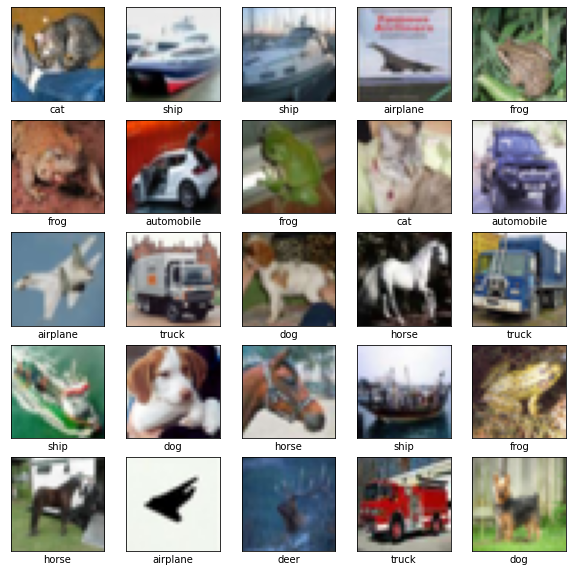

In [108]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(test_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[test_labels[i][0]])
plt.show()

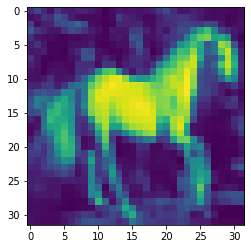

In [35]:
# this images where in the center pixels are focussed (diagonally) looks like a shape of a horse
plt.imshow(test_images[13,:,:,2])

In [10]:
horse_train_images = []
horse_train_labels = []

for i in range(len(train_images)):
  if(train_labels[i] == 7):
    horse_train_images.append(train_images[i])
    horse_train_labels.append(train_labels[i])

horse_train_images = np.array(horse_train_images)
print(horse_train_images.shape)

horse_train_labels = np.array(horse_train_labels)
print(horse_train_labels.shape)

horse_test_images =  []
horse_test_labels = []

for i in range(len(test_images)):
  if(test_labels[i] == 7):
    horse_test_images.append(test_images[i])
    horse_test_labels.append(test_labels[i])
    
horse_test_images = np.array(horse_test_images)
print(horse_test_images.shape)

horse_test_labels = np.array(horse_test_labels)
print(horse_test_labels.shape)

#  converting numpy arrays to tensors for truck dataset

horse_train_images_tensor = tf.convert_to_tensor(horse_train_images,dtype=tf.float32)
print(horse_train_images_tensor.shape)

horse_train_labels_tensor = tf.convert_to_tensor(horse_train_labels,dtype=tf.float32)
print(horse_train_labels_tensor.shape)

horse_test_images_tensor = tf.convert_to_tensor(horse_test_images,dtype=tf.float32)
print(horse_test_images_tensor.shape)

horse_test_labels_tensor = tf.convert_to_tensor(horse_test_labels,dtype=tf.float32)
print(horse_test_labels_tensor.shape)

(5000, 32, 32, 3)
(5000, 1)
(1000, 32, 32, 3)
(1000, 1)
(5000, 32, 32, 3)
(5000, 1)
(1000, 32, 32, 3)
(1000, 1)


In [11]:
truck_train_images = []
truck_train_labels = []

for i in range(len(train_images)):
  if(train_labels[i] == 9):
    truck_train_images.append(train_images[i])
    truck_train_labels.append(train_labels[i])

truck_train_images = np.array(truck_train_images)
print(truck_train_images.shape)

truck_train_labels = np.array(truck_train_labels)
print(truck_train_labels.shape)

truck_test_images =  []
truck_test_labels = []

for i in range(len(test_images)):
  if(test_labels[i] == 9):
    truck_test_images.append(test_images[i])
    truck_test_labels.append(test_labels[i])
    
truck_test_images = np.array(truck_test_images)
print(truck_test_images.shape)

truck_test_labels = np.array(truck_test_labels)
print(truck_test_labels.shape)

#  converting numpy arrays to tensors for truck dataset

truck_train_images_tensor = tf.convert_to_tensor(truck_train_images,dtype=tf.float32)
print(truck_train_images_tensor.shape)

truck_train_labels_tensor = tf.convert_to_tensor(truck_train_labels,dtype=tf.float32)
print(truck_train_labels_tensor.shape)

truck_test_images_tensor = tf.convert_to_tensor(truck_test_images,dtype=tf.float32)
print(truck_test_images_tensor.shape)

truck_test_labels_tensor = tf.convert_to_tensor(truck_test_labels,dtype=tf.float32)
print(truck_test_labels_tensor.shape)

(5000, 32, 32, 3)
(5000, 1)
(1000, 32, 32, 3)
(1000, 1)
(5000, 32, 32, 3)
(5000, 1)
(1000, 32, 32, 3)
(1000, 1)


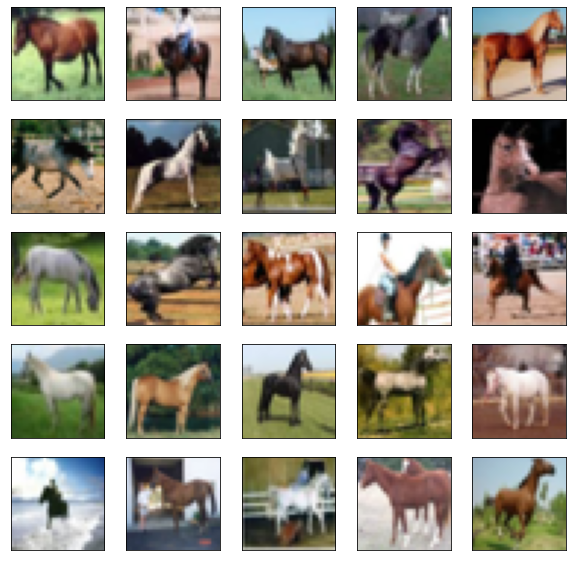

In [114]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(horse_train_images[i], cmap=plt.cm.binary)
plt.show()

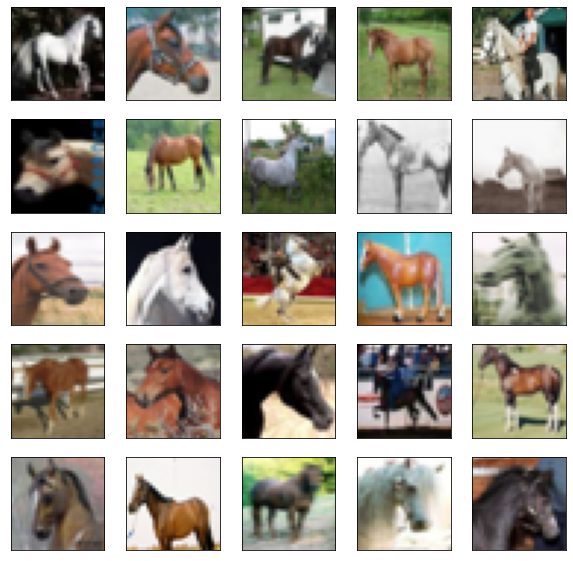

In [45]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(horse_test_images[i], cmap=plt.cm.binary)
plt.show()

In [129]:
img_batch = tf.expand_dims(truck_test_images[3], axis=0)   #converting one image to batch and checking softmax output

layer_activations = new_model(img_batch)
print(np.argmax(layer_activations))   
print(img_batch.shape)

9
(1, 32, 32, 3)


In [120]:
layer_activations_test = new_model.predict(horse_test_images[0:10,:,:,:])
layer_activations_train = new_model(horse_train_images[0:10,:,:,:])
# print(layer_activations_test)  
print(layer_activations_train) 

tf.Tensor(
[[8.92745993e-06 2.09571070e-07 3.14767349e-05 1.66835762e-05
  3.16896803e-05 8.94756377e-05 4.23696605e-07 9.99820292e-01
  1.26377103e-07 5.55244810e-07]
 [1.84624092e-04 8.54807604e-06 6.30773371e-04 2.61286413e-03
  4.63466207e-03 3.08729173e-03 5.91599091e-05 9.88714755e-01
  1.82869735e-05 4.89795239e-05]
 [4.59299590e-05 1.49189475e-06 7.29450840e-05 4.94517270e-04
  2.17463748e-04 8.78550869e-04 3.71981764e-06 9.98272419e-01
  2.19354365e-06 1.08095801e-05]
 [1.27131625e-05 8.31774059e-07 4.86258541e-05 1.62167358e-04
  4.51916858e-05 7.72552739e-04 1.53943836e-06 9.98952746e-01
  6.59322893e-07 2.90074422e-06]
 [4.74846411e-06 6.87869885e-08 8.34054845e-06 1.16935553e-05
  2.24294286e-06 5.90456584e-05 7.40244985e-08 9.99913454e-01
  6.95707598e-08 3.46191143e-07]
 [1.19318058e-04 1.19799497e-05 7.83020165e-04 3.65509884e-03
  4.73903026e-03 5.61714498e-03 1.18828182e-04 9.84882653e-01
  1.93741325e-05 5.36172411e-05]
 [2.68202682e-04 3.41649206e-06 3.90504370e-04 

In [6]:
# creating mask we are considering 7th index(horse) for masking
mask_horse = tf.tile(tf.Variable(initial_value=tf.constant([0,0,0,0,0,0,0,1,0,0], dtype="float32", shape=(1,10))) , multiples=[1000,1])

In [15]:
def calculating_loss(input_classes,masked_softmax_output):
  losses = []
  print(input_classes.shape,masked_softmax_output.shape)
  losses.append(tf.keras.losses.sparse_categorical_crossentropy(input_classes,masked_softmax_output))
  return losses

In [22]:
def gradient_based_saliency(horse_test_images_tensor,horse_test_labels_tensor,mask_horse):
  with tf.GradientTape() as tape:
    masked_softmax_output = []
    tape.watch(horse_test_images_tensor)

    horse_prediction = new_model(horse_test_images_tensor)
    masked_softmax_output =  tf.multiply(mask_horse, horse_prediction)
 
    losses = calculating_loss(horse_test_labels_tensor,masked_softmax_output)

    gradients_after_masking = []

  for loss in losses:
    gradients_after_masking.append(tape.gradient(loss,horse_test_images_tensor))

    return gradients_after_masking

In [23]:
final_gradients = gradient_based_saliency(horse_test_images_tensor,horse_test_labels_tensor,mask_horse)

(1000, 1) (1000, 10)


In [27]:
# all saliency maps for horse dataset

final_gradients

[<tf.Tensor: shape=(1000, 32, 32, 3), dtype=float32, numpy=
 array([[[[ 1.45120005e-12, -1.75445249e-11, -2.43152005e-12],
          [-1.66887233e-11, -5.02948620e-11, -2.94711963e-11],
          [ 3.41623535e-11,  1.52081993e-11,  1.63635373e-11],
          ...,
          [-4.65163151e-11, -6.55899085e-11, -7.54939999e-11],
          [ 7.33321945e-11,  5.98416525e-11,  2.85052398e-11],
          [ 6.76758233e-11,  3.60730647e-11,  2.73278067e-11]],
 
         [[ 6.21475961e-13, -2.57749655e-11, -5.18757736e-12],
          [ 3.02554440e-11, -5.60265237e-11, -3.66473588e-11],
          [ 1.83670718e-11, -8.73427580e-11, -8.02038713e-11],
          ...,
          [ 1.77177328e-10,  1.50734300e-10,  1.19133536e-10],
          [ 1.93857042e-10,  1.58359464e-10,  1.55429503e-10],
          [-4.23389900e-11, -8.92600507e-11, -5.17404522e-11]],
 
         [[-9.02418158e-12, -1.01993691e-11,  6.07773640e-12],
          [ 9.19333359e-11,  3.32180047e-11,  8.79959994e-11],
          [ 1.31724839

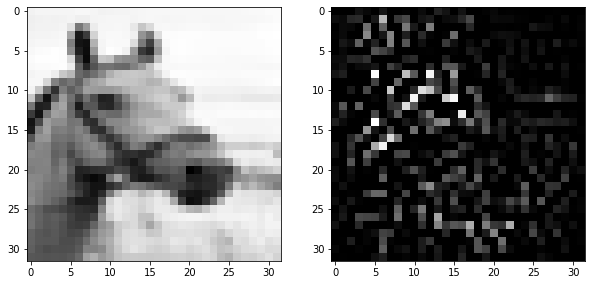

In [74]:
%matplotlib inline
fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1, 2, 1)
plt.imshow(horse_test_images_tensor[10,:,:,0],cmap=plt.cm.Greys_r)
a = fig.add_subplot(1, 2, 2)
plt.imshow(tf.nn.relu(final_gradients[0][10,:,:,0]),cmap=plt.cm.Greys_r)

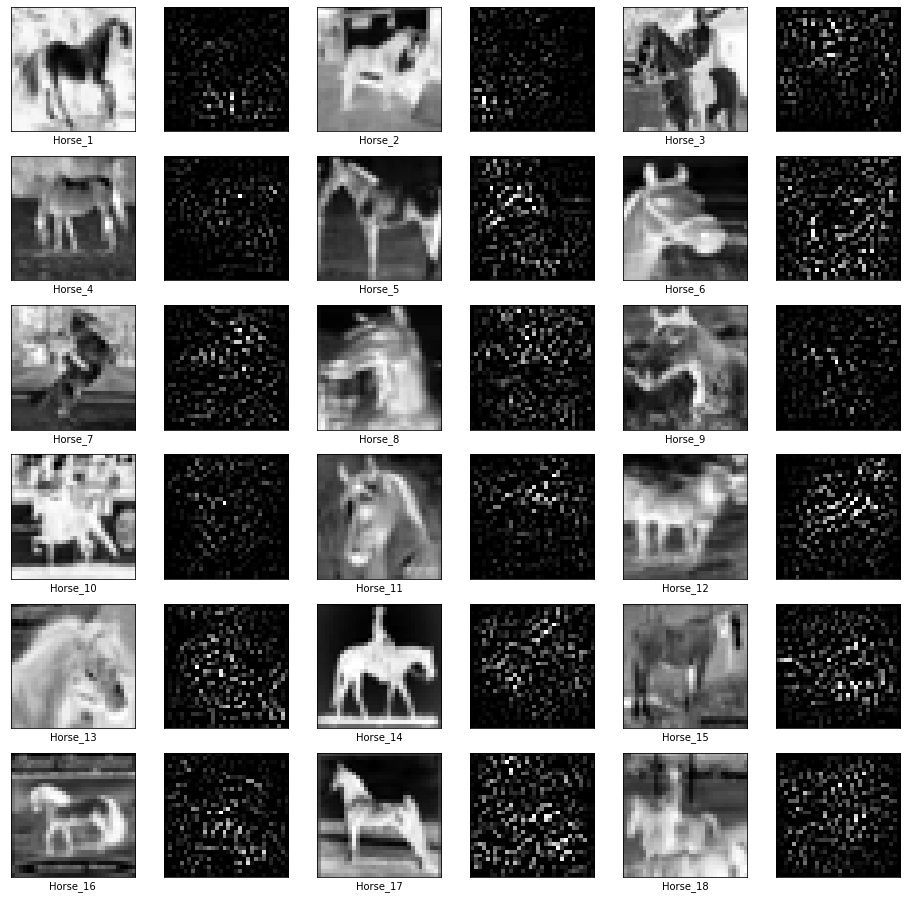

In [75]:
plt.figure(figsize=(16,16))
counter = 1
for i in range(36):
  k = i+1
  plt.subplot(6,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  if i%2 == 0:
    plt.imshow(horse_test_images_tensor[i,:,:,0], cmap=plt.cm.binary)
    plt.xlabel("Horse_" + str(counter))
    counter = counter+1
  else:
    plt.imshow(tf.nn.relu(final_gradients[0][k,:,:,0]), cmap=plt..cm.Greys_r)
plt.show()


We have tried to capture gradient based saliency maps by masking the softmax outputs, as described in introspection lecture, there could be many ways to do feature visualization for eg: neuron, channel, layer, logits and probability. We have considered softmax output/probability.

Out of many ways of looking at saliency maps, we have implemented gradient based saliency maps . As described in slide 14 of lecture notes, we need to mask feature map which we get from the forward pass and then compute gradients for masked feature map. This backpropagation results in a saliency map which is shown in images above. 

**Ques Do the saliency maps seem to make sense? How would you interpret them?**

We have splited the dataset in a way to consider only horses and have created a mask for horses. For few images, for example for Horse_11 the bright pixels(white) are seen in the area of face which can be intepreted as those pixels are contributing more towards the classification, similarly for Horse_12 the bright pixels are contributing. But there are some maps which are not making sense, for example for Horse_18 the bright pixels are in empty space in the right top corner of the image.


## 4.2 Activation Maximization

Extend the code from 4.1 to create an optimal input for a particular class.

- Add the gradients (i.e. the saliency map) to the input. You should multiply the gradients with a small constant (like a learning rate) to make sure the inputs aren’t changed too much.
- Do multiple update steps to make the input more optimal for the chosen output class.
(I recommend implementing your own update step, but you are allowed to use a keras training loop to optimize the input.)

Does the resulting input look natural?
How does the inputs change when applying many steps of optimization?
How do the optimal inputs differ when initializing the optimization with random noise instead of real examples?

In [128]:
# creating mask we are considering 7th index(horse) for masking
mask_horse = tf.tile(tf.Variable(initial_value=tf.constant([0,0,0,0,0,0,0,1,0,0], dtype="float32", shape=(1,10))) , multiples=[1,1])

In [148]:
def calculating_loss(input_classes,masked_softmax_output):
  loss = tf.keras.losses.sparse_categorical_crossentropy(input_classes,masked_softmax_output)
  return loss

In [149]:
def saliency_map(horse_test_images_tensor,horse_test_labels_tensor,mask_horse):
  learning_rate = 1000
  with tf.GradientTape() as tape:
    masked_softmax_output = []
    tape.watch(horse_test_images_tensor)

    horse_prediction = new_model(horse_test_images_tensor)
    masked_softmax_output =  tf.multiply(mask_horse, horse_prediction)

    loss = calculating_loss(horse_test_labels_tensor,masked_softmax_output)

    gradients_after_masking = tape.gradient(loss,horse_test_images_tensor)

  gradient_multiply = gradients_after_masking * learning_rate

  return gradient_multiply

In [111]:
gradient_multiply = saliency_map(horse_test_images_tensor,horse_test_labels_tensor,mask_horse)

(1000, 1) (1000, 10)


In [166]:
def maximization(horse_test_images_tensor,horse_test_labels_tensor,param='add'):
  count = 0
  list_softmax_output = []
  for step in range(50):    #update steps
    if step == 0:

        gradient_multiply = saliency_map(horse_test_images_tensor,horse_test_labels_tensor,mask_horse)
        if param == 'add':
          new_horse_test_images_tensor = tf.add(horse_test_images_tensor, gradient_multiply)
        else:
          new_horse_test_images_tensor = tf.subtract(horse_test_images_tensor, gradient_multiply)
    elif step>0:

        gradient_multiply = saliency_map(new_horse_test_images_tensor,new_predictions,mask_horse)
        if param == 'add':
          new_horse_test_images_tensor = tf.add(new_horse_test_images_tensor, gradient_multiply)
        else:
          new_horse_test_images_tensor = tf.subtract(new_horse_test_images_tensor, gradient_multiply)


    softmax_output = new_model(new_horse_test_images_tensor)

    new_predictions = tf.cast(tf.argmax(softmax_output,axis=1),dtype=tf.dtypes.float32)
    list_softmax_output.append(softmax_output[0][7])
  plt.plot(list_softmax_output)
  return new_horse_test_images_tensor

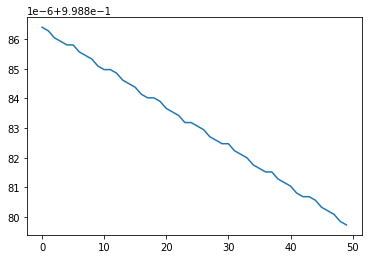

In [167]:
new_horse_test_images_tensor = maximization(horse_test_images_tensor[0:1,:,:,:],horse_test_labels_tensor[0:1],'add')

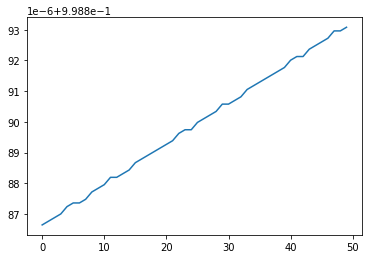

In [168]:
new_horse_test_images_tensor = maximization(horse_test_images_tensor[0:1,:,:,:],horse_test_labels_tensor[0:1],param='subtract')

In [162]:
horse_test_images_tensor[0] - new_horse_test_images_tensor[0]

<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[ 0.0000000e+00, -7.4505806e-07,  0.0000000e+00],
        [-7.4505806e-07, -2.9802322e-06, -1.4901161e-06],
        [ 1.4901161e-06,  7.4505806e-07,  7.4505806e-07],
        ...,
        [-2.2351742e-06, -3.3527613e-06, -3.7252903e-06],
        [ 3.7252903e-06,  2.9802322e-06,  1.3969839e-06],
        [ 3.3527613e-06,  1.8626451e-06,  1.3038516e-06]],

       [[ 0.0000000e+00, -1.2889504e-06, -1.8626451e-07],
        [ 1.4901161e-06, -2.8610229e-06, -1.8626451e-06],
        [ 7.4505806e-07, -4.4703484e-06, -3.7848949e-06],
        ...,
        [ 8.9332461e-06,  7.5437129e-06,  5.9604645e-06],
        [ 9.6857548e-06,  7.9162419e-06,  7.8100711e-06],
        [-2.2351742e-06, -4.4703484e-06, -2.6077032e-06]],

       [[-7.4505806e-07, -7.4505806e-07,  0.0000000e+00],
        [ 4.4703484e-06,  1.5199184e-06,  4.4703484e-06],
        [ 6.7055225e-06,  2.2351742e-06,  5.5879354e-06],
        ...,
        [ 1.8626451e-06,  2.048909

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


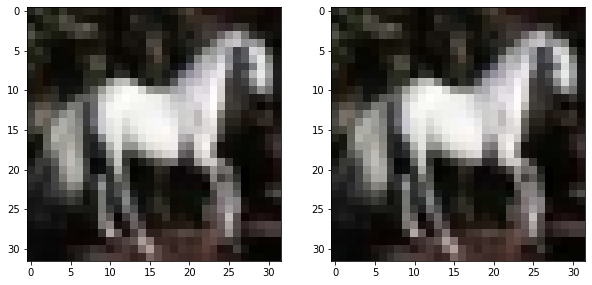

In [160]:
%matplotlib inline
fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1, 2, 1)
plt.imshow(horse_test_images_tensor[0],cmap=plt.cm.viridis)
a = fig.add_subplot(1, 2, 2)
plt.imshow(new_horse_test_images_tensor[0],cmap=plt.cm.viridis)


Above right hand side image is the result and it is looking natural.

In our case, input changed very less, and generated input and original input has hardly any noticiable difference. 

# Task 5 Attention-based Neural Machine Translation

**Tasks:**

- Follow the tutorial and train the model on your chosen language pair (using Bahdanau attention).
- You might need to adapt the preprocessing depending on the language.
- Implement other attention mechanisms and train models with them
   - dot product attention 
   - Luong’s multiplicative attention 

**References:**

https://www.tensorflow.org/tutorials/text/nmt_with_attention (This tutorial is followed and variable, class and functions names are same)

https://github.com/thisisiron/nmt-attention-tf2/blob/master/model.py and https://machinetalk.org/2019/03/29/neural-machine-translation-with-attention-mechanism/     ~ for Loung's Multiplicative Attention


**For this Task we have considered French Dataset**

In [161]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset

In [162]:
# Download the file
# path_to_zip = '/content/drive/My Drive/Colab Notebooks/hin-eng..zip'

# path_to_file = os.path.dirname(path_to_zip)+"/hin-eng/hin.txt"

path_to_dir = '/content/drive/My Drive/Colab Notebooks'
path_to_file = path_to_dir + "/fra.txt"

In [163]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  w = w.strip()
  w = '<start> ' + w + ' <end>'
  return w

In [5]:
# en_sentence = u"This is a book"
# hin_sentence = u"यह एक किताब है।"
# print(preprocess_sentence(en_sentence))
# print(preprocess_sentence(hin_sentence).encode('utf-8'))

In [164]:
en_sentence = u"I can't walk."
fra_sentence = u"Je ne peux marcher."
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(fra_sentence).encode('utf-8'))

<start> i can t walk . <end>
b'<start> je ne peux marcher . <end>'


In [165]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, FRENCH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [166]:
en, fra, _ = create_dataset(path_to_file, None)

In [9]:
print(en[-5])
print(fra[-5])

<start> top down economics never works , said obama . the country does not succeed when just those at the very top are doing well . we succeed when the middle class gets bigger , when it feels greater security . <end>
<start> l economie en partant du haut vers le bas , ca ne marche jamais , a dit obama . le pays ne reussit pas lorsque seulement ceux qui sont au sommet s en sortent bien . nous reussissons lorsque la classe moyenne s elargit , lorsqu elle se sent davantage en securite . <end>


In [10]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [11]:
def load_dataset(path, num_examples=None):
  targ_lang, inp_lang, _= create_dataset(path, num_examples)
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [12]:
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [13]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [167]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [181]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[7054])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[7054])

Input Language; index to word mapping
1 ----> <start>
4 ----> je
20 ----> suis
5050 ----> organise
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
16 ----> m
3203 ----> organized
3 ----> .
2 ----> <end>


In [16]:
# Create a tf.data dataset

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [17]:
example_input_batch, example_target_batch = next(iter(dataset))
tf.print(example_input_batch.shape, example_target_batch.shape)

TensorShape([64, 17]) TensorShape([64, 10])


In [18]:
#  Write the encoder and decoder model

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [19]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 17, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


## Bahdanau attention

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 17, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4367)


### Define the optimizer, the loss function and the check points

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './BahdanauAttention_training_checkpoints' 
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder, decoder=decoder)

### Bahadanu Training

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.9248
Epoch 1 Batch 100 Loss 2.0384
Epoch 1 Batch 200 Loss 1.8645
Epoch 1 Batch 300 Loss 1.7201
Epoch 1 Loss 2.0071
Time taken for 1 epoch 44.20048642158508 sec

Epoch 2 Batch 0 Loss 1.4854
Epoch 2 Batch 100 Loss 1.4274
Epoch 2 Batch 200 Loss 1.4689
Epoch 2 Batch 300 Loss 1.2314
Epoch 2 Loss 1.3052
Time taken for 1 epoch 32.90579915046692 sec

Epoch 3 Batch 0 Loss 0.9449
Epoch 3 Batch 100 Loss 0.8896
Epoch 3 Batch 200 Loss 0.9293
Epoch 3 Batch 300 Loss 0.7718
Epoch 3 Loss 0.8910
Time taken for 1 epoch 31.824654817581177 sec

Epoch 4 Batch 0 Loss 0.6651
Epoch 4 Batch 100 Loss 0.6055
Epoch 4 Batch 200 Loss 0.5950
Epoch 4 Batch 300 Loss 0.5663
Epoch 4 Loss 0.5876
Time taken for 1 epoch 32.96657156944275 sec

Epoch 5 Batch 0 Loss 0.3954
Epoch 5 Batch 100 Loss 0.3960
Epoch 5 Batch 200 Loss 0.4110
Epoch 5 Batch 300 Loss 0.3890
Epoch 5 Loss 0.3833
Time taken for 1 epoch 32.025142192840576 sec

Epoch 6 Batch 0 Loss 0.2708
Epoch 6 Batch 100 Loss 0.2278
Epoch 6 Batch 200 Lo

### Translate - Evaluation

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis',clim=[0,1])

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Restore the latest checkpoint and test

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> . je suis a boston . <end>
Predicted translation: i m losing . <end> 


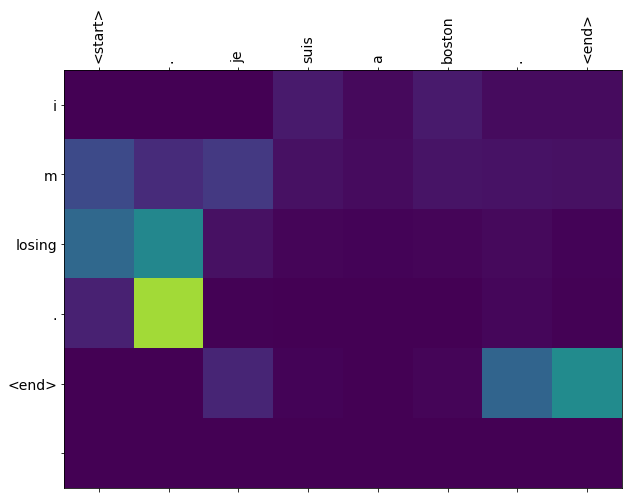

In [ ]:
# wrong translation I am in Boston
translate(u'.Je suis à Boston.')

Input: <start> tom est en vie . <end>
Predicted translation: tom is alive . <end> 


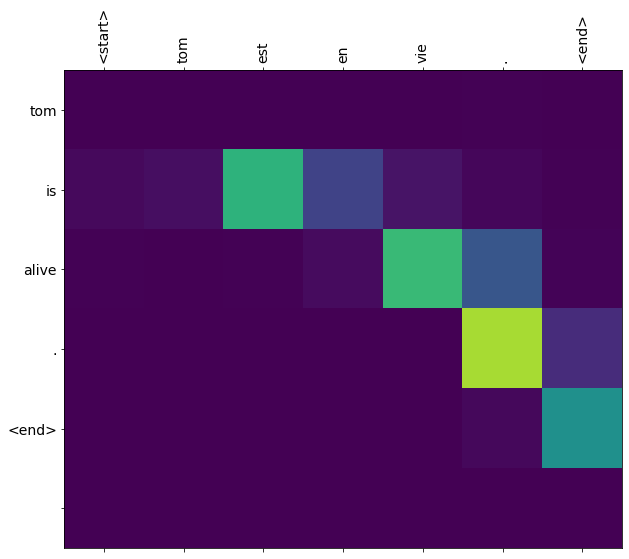

In [ ]:
# correct translation
translate(u'Tom est en vie.')

## Dot Product attention

In [159]:
class DotAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(DotAttention, self).__init__()

  def call(self, query, values):

    query_with_time_axis = tf.expand_dims(query, 1)

    score_value = tf.multiply(query_with_time_axis, values)
    score_value = tf.reduce_sum(score_value,-1)
    score_value = tf.expand_dims(score_value,-1)

    attention_weights = tf.nn.softmax(score_value, axis=1)

 
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [160]:
attention_layer = DotAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 17, 1)


In [145]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = DotAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [146]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4367)


### Define the optimizer, the loss function and the check points

In [147]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [148]:
checkpoint_dir = './DotAttention_training_checkpoints' 
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder, decoder=decoder)

### Dot Product Training

In [149]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [150]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7794
Epoch 1 Batch 100 Loss 1.3782
Epoch 1 Batch 200 Loss 1.1813
Epoch 1 Batch 300 Loss 1.0403
Epoch 1 Loss 1.4022
Time taken for 1 epoch 63.589439153671265 sec

Epoch 2 Batch 0 Loss 0.7677
Epoch 2 Batch 100 Loss 0.6921
Epoch 2 Batch 200 Loss 0.7023
Epoch 2 Batch 300 Loss 0.5802
Epoch 2 Loss 0.6649
Time taken for 1 epoch 51.370848655700684 sec

Epoch 3 Batch 0 Loss 0.4494
Epoch 3 Batch 100 Loss 0.5112
Epoch 3 Batch 200 Loss 0.4102
Epoch 3 Batch 300 Loss 0.4826
Epoch 3 Loss 0.4160
Time taken for 1 epoch 50.727555990219116 sec

Epoch 4 Batch 0 Loss 0.2044
Epoch 4 Batch 100 Loss 0.3463
Epoch 4 Batch 200 Loss 0.2405
Epoch 4 Batch 300 Loss 0.2502
Epoch 4 Loss 0.2724
Time taken for 1 epoch 51.64696192741394 sec

Epoch 5 Batch 0 Loss 0.1496
Epoch 5 Batch 100 Loss 0.1916
Epoch 5 Batch 200 Loss 0.1386
Epoch 5 Batch 300 Loss 0.1426
Epoch 5 Loss 0.1869
Time taken for 1 epoch 50.71563148498535 sec

Epoch 6 Batch 0 Loss 0.1324
Epoch 6 Batch 100 Loss 0.1314
Epoch 6 Batch 200 L

### Translate - Evaluation

In [151]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [152]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis',clim=[0,1])

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [153]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Restore the latest checkpoint and test

In [154]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> . je suis a boston . <end>
Predicted translation: i m in boston . <end> 


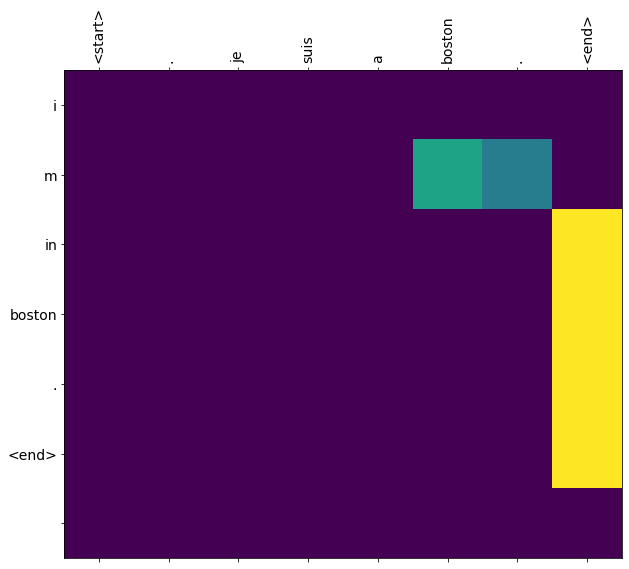

In [155]:
# correct translation
translate(u'.Je suis à Boston.')

Input: <start> tom est en vie . <end>
Predicted translation: tom s alive . <end> 


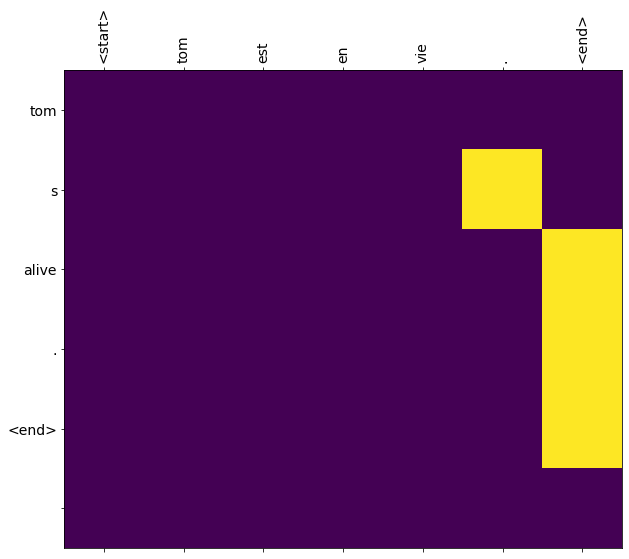

In [156]:
# wrong translation it should be Tom is alive.
translate(u'Tom est en vie.')

## Luong’s multiplicative attention

In [112]:
class LuongMultiAttention(tf.keras.layers.Layer):

  def __init__(self, units):
    super(LuongMultiAttention, self).__init__()
    self.Wa = tf.keras.layers.Dense(units)

  def call(self, query, values):
     query_with_time_axis = tf.expand_dims(query, 1)

     score_value = tf.matmul(self.Wa(query_with_time_axis), values, transpose_b=True)
     new_score = tf.transpose(score_value, [0, 2, 1])

     attention_weights = tf.nn.softmax(new_score, axis=1)

     context_vector = attention_weights * values
     context_vector = tf.reduce_sum(context_vector, axis=1)


     return context_vector, attention_weights

In [102]:
attention_layer = LuongMultiAttention(1024)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 1, 17)


In [115]:
# Since shape for attention weights is coming 64,1,17 we can transpose the matrix to get shape 64,17,1
attention_layer = LuongMultiAttention(1024)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 17, 1)


In [118]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = LuongMultiAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [119]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4367)


### Define the optimizer, the loss function and the check points

In [120]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [121]:
checkpoint_dir = './LuongMultiAttention_training_checkpoints' 
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder, decoder=decoder)

### Luong's Multiplicative Training

In [122]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [123]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.9111
Epoch 1 Batch 100 Loss 2.2564
Epoch 1 Batch 200 Loss 2.0254
Epoch 1 Batch 300 Loss 1.8377
Epoch 1 Loss 2.1186
Time taken for 1 epoch 63.668105363845825 sec

Epoch 2 Batch 0 Loss 1.5670
Epoch 2 Batch 100 Loss 1.4982
Epoch 2 Batch 200 Loss 1.5015
Epoch 2 Batch 300 Loss 1.3838
Epoch 2 Loss 1.5045
Time taken for 1 epoch 51.08575487136841 sec

Epoch 3 Batch 0 Loss 1.2115
Epoch 3 Batch 100 Loss 1.3413
Epoch 3 Batch 200 Loss 1.2183
Epoch 3 Batch 300 Loss 1.2919
Epoch 3 Loss 1.2987
Time taken for 1 epoch 49.94578194618225 sec

Epoch 4 Batch 0 Loss 1.2009
Epoch 4 Batch 100 Loss 1.1251
Epoch 4 Batch 200 Loss 1.0477
Epoch 4 Batch 300 Loss 0.9652
Epoch 4 Loss 1.0822
Time taken for 1 epoch 51.080387115478516 sec

Epoch 5 Batch 0 Loss 0.8631
Epoch 5 Batch 100 Loss 0.8902
Epoch 5 Batch 200 Loss 1.0349
Epoch 5 Batch 300 Loss 0.7899
Epoch 5 Loss 0.8686
Time taken for 1 epoch 49.81519365310669 sec

Epoch 6 Batch 0 Loss 0.7571
Epoch 6 Batch 100 Loss 0.7383
Epoch 6 Batch 200 Lo

### Translate - Evaluation

In [124]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [125]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis',clim=[0,1])

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [126]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Restore the latest checkpoint and test

In [127]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> . je suis a boston . <end>
Predicted translation: i m in boston . <end> 


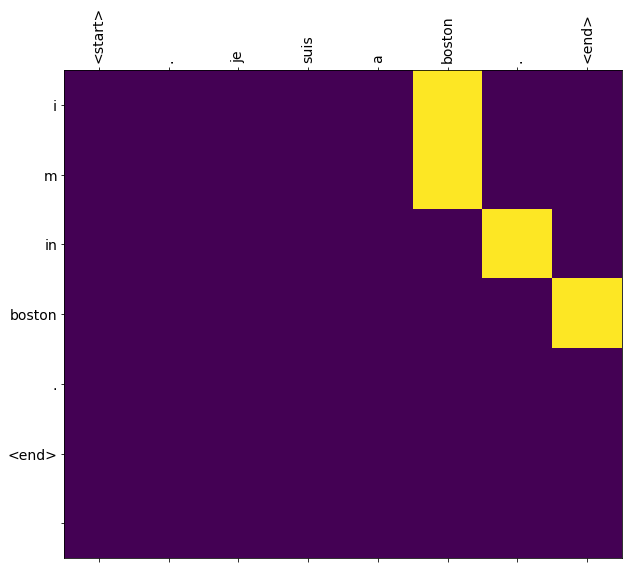

In [128]:
# Correct translation
translate(u'.Je suis à Boston.')

Input: <start> tom est en vie . <end>
Predicted translation: tom is life . <end> 


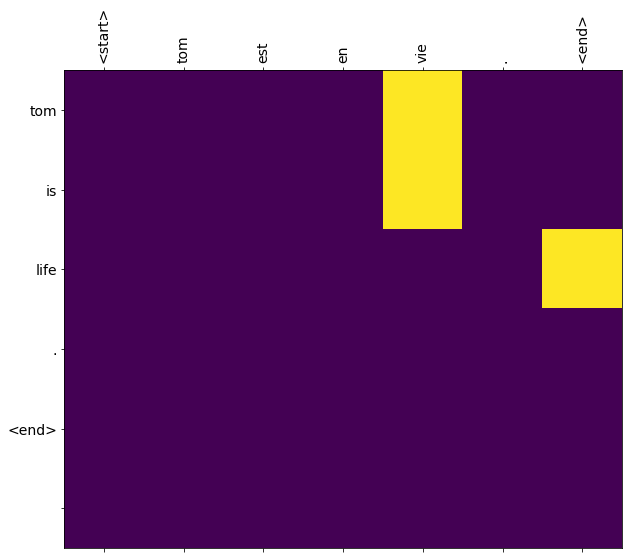

In [129]:
# wrong translation  It should be Tom is alive.
translate(u'Tom est en vie.')

## Questions 



**Ques1 Which parts of the sentence are used as a token? Each character, each word, or are some words split up?**

For tokens- words are indexed and used. But there is exceptions like:

en_sentence = u"I can't walk." 

when this sentence was passed to function preprocess_sentence output came something like this:

start i can t walk . end

So words with apostrophe gets split up.


**Ques2 Do the same tokens in different language have the same ID?e.g. Would the same token index map to the German word die and to the English word die?**

<figure>
<center>
<img src='https://drive.google.com/uc?id=1MQjATvLyvFH397sth8_kP_tMPebKq_bE' />
</center>
</figure>

We can see in the image word organize is same for english and french but has different index/id values. Probability of same tokens in different languages having same id is very rare.

**Ques3 What is the relation between the encoder output and the encoder hidden state which is used to initialize the decoder hidden state?(for the architecture used in the tutorial)**
 
Relation between encoder output and encoder hidden state is:

Encoder output shape: (batch size, sequence length, units) (64, 17, 1024)

Encoder Hidden state shape: (batch size, units) (64, 1024)


**Ques4 Is the decoder attending to all previous positions, including the previous decoder predictions?**

As we can see in the diagram which is adapted from Luong's paper available in NMT tutorial, decoder is attending to all the encoder states with varied attention weights and also, attending to it's previous prediction..

**Ques5 Does the Encoder output change in different decoding steps?**

No Encoder output will not change in different decoding steps. To explain it, I would like to take this reference from http://www.wildml.com/2016/01/attention-and-memory-in-deep-learning-and-nlp/ where author is saying:

" that each decoder output word depends on a weighted combination of all the input states. There are weights that define how much of each input state should be considered for each output."

**Ques6 Does the context vector change in different decoding steps?**

Yes, context vector will change as different amount of attention will be paid to different input states in different decoding steps depending on which part is being focussed.

**Ques7 The decoder uses teacher forcing. Does this mean the time steps can be computed in parallel?**

According to the steps defined in NMT tutorial, they are making use of teacher forcing for deciding next input to the decoder, but also hidden states are also involved with encoder and decoder. So, in this case, we can't computer time steps in parallel. But, if we had no hidden-to-hidden connections and just teacher forcing, we can computer time steps in parallel in that case.

**Ques8 Why is a mask applied to the loss function?**

 With mask, we are just masking out irrelevant values in the loss function. Without masking we will be calculating the loss for padded position which is not required.


# Our Findings for Task 4 and 5

**Sanjeeth:**

**Task 4**

- While observing the saliency maps of the dataset, I noticed that for certain images of horses the brighter pixels were actually pointing to the exact positioning of the horse, but in few saliency maps the brighter pixels are pointing to the irrelevant positions.
- In activation maximization, tf.add function decreases softmax value as plotted in the curve.
- I have subtracted the input[0] values from the generated input[0] and both the tensors are different.

**Task 5**

- Training time for the model using Bahdanau attention is almost half compared to rest of the two models.

**Himanshi:**

**Task 4**

- tf.subtract worked in our case to maximize the output value, and not tf.add, as the saliency maps/gradients had negative values.
- I have run the loop for 10,50,100 and 500 times to generate new image and check the plot curve for both tf.add and tf.subtract, for tf.subtract softmax value for horse kept increasing and plotted the graph for the same.


**Task 5**

- Experimented with two sentences for 3 different attention mechanism and sentence correctly translated by one model is wrongly translated by other.
